# 코인판 크롤러 프로그램

해당 프로그램은 2022년 12월에 제작됐으며, 향후 코인판 홈페이지의 개편이나 보안 강화가 이뤄질 경우, 해당 프로그램이 작동되지 않을 수 있습니다.

In [1]:
#module import 

import time
import json
import urllib
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from konlpy.tag import Okt

okt = Okt()

In [2]:
#setting plt font & size

plt.rcParams["font.family"] = "Hancom MalangMalang"
plt.rcParams['figure.figsize'] = 10,10
sns.set(font="Hancom MalangMalang", rc={"axes.unicode_minus":False}, style='white')

In [3]:
#definate function

def word_counter(value, key_words):
    for i in value:
        if i not in key_words:
            key_words[i] = 1 #최초 언어
        elif i in key_words:
            key_words[i] += 1 #중복 언어
    return key_words


def no_space(text):
    a = re.sub("\n", "", text)
    b = re.sub("  ", "", a)
    c = re.sub("[0-9]+ ", "", b)
    return c


def tokenizer(text):
    lis = []
    for i in text:
        word = okt.nouns(i) #토큰화
        for k in word:
            lis.append(k)
    return lis


def counter_to_DataFrame(key_words):
    word_df = pd.DataFrame(key_words.items()) #Data Frame 형성
    word_df.columns = ['단어', '빈도']
    word_df = word_df.sort_values(['빈도'],ascending = False).reset_index(drop = True) #내림차순 정렬
    return word_df


## 크롤링 프로그램
하단의 프로그램을 통해 코인판의 내용을 크롤링 할 수 있습니다

In [14]:
iter = 50  #몇 페이지까지 크롤링 할 것인지?

In [15]:
key_words = {}
token_list = []
words = []

# options = webdriver.ChromeOptions()
# options.add_argument("--headless")
# options.add_argument('--window-size=1920x1080')
# options.add_argument("--disble-gpu")

driver = webdriver.Chrome(ChromeDriverManager().install())
driver.implicitly_wait(5)

url = 'https://coinpan.com/index.php?mid=free&page=1'
driver.get(url)


for i in range(3, iter + 3):
    
    word_lis = []
        
    #딜레이 생성
    seed = np.random.randint(100)
    np.random.seed(seed)
    a = np.random.randint(5)
    time.sleep(a)
    
    
    for j in range(7,26):
        title = driver.find_element_by_css_selector(f'table > tbody > tr:nth-child({j}) > td.title > a').get_attribute('text')
        name = driver.find_element_by_css_selector(f'table > tbody > tr:nth-child({j}) > td.author > a').get_attribute('text')
        date = driver.find_element_by_xpath(f'//*[@id="board_list"]/table/tbody/tr[{j}]/td[4]/span').get_attribute('innerText')
        freq = driver.find_element_by_xpath(f'//*[@id="board_list"]/table/tbody/tr[{j}]/td[5]/span').get_attribute('innerText')
        title = no_space(title)
        
        words.append([title, name, date, freq])
        word_lis.append(title)
    token = tokenizer(word_lis) #tokenizer
    key_words = word_counter(token, key_words) #Counter Dict 형성
    
    if i <= 7:
        driver.find_element_by_xpath(f'//*[@id="view_198_0"]/div[2]/div/ul/li[{i}]/a').click()
        time.sleep(3)
    else : 
        driver.find_element_by_xpath('//*[@id="view_198_0"]/div[2]/div/ul/li[8]/a').click()
        time.sleep(3)


driver.quit()

df = pd.DataFrame(words, columns=['제목', '작성자', '시간', '조회수'])

counter = counter_to_DataFrame(key_words) #Data Frame으로 변환
counter = counter[counter['단어'].str.len() > 1]
counter.reset_index(drop=True, inplace=True)

In [16]:
top_count = counter.head(30) #상위 20개 단어 추출

<AxesSubplot: xlabel='빈도', ylabel='단어'>

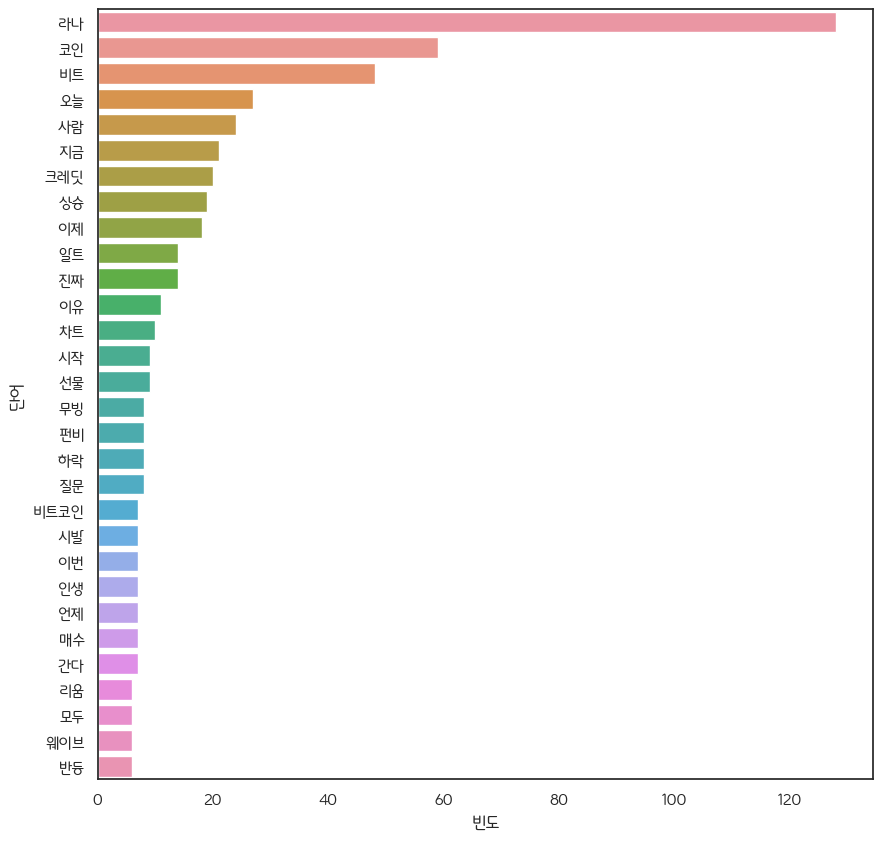

In [17]:
sns.barplot(data = top_count, x = '빈도', y = '단어')

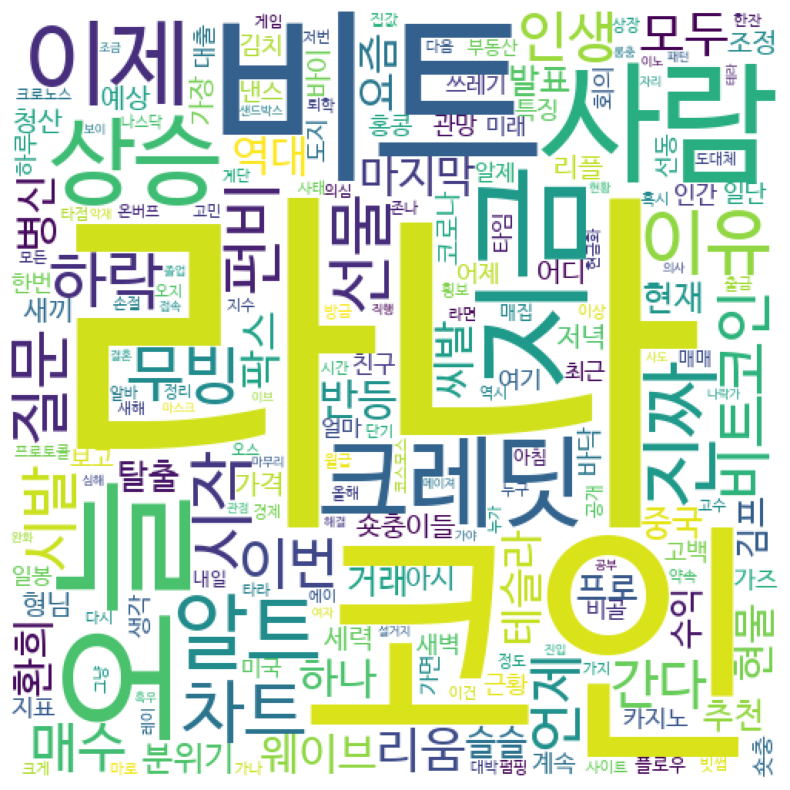

In [18]:
#WordCloud 형성
wc = WordCloud(font_path = './NanumBarunGothic.ttf', #폰트 위치(사용자에 맞게 설정)
    width = 500,
    height = 500,
    background_color='white').generate_from_frequencies(counter.set_index('단어').to_dict()['빈도'])


plt.figure(figsize = (10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [19]:
names = pd.DataFrame(df.groupby('작성자').size().sort_values(ascending = False)).reset_index()
names.columns = ['작성자', '빈도']

<AxesSubplot: xlabel='빈도', ylabel='작성자'>

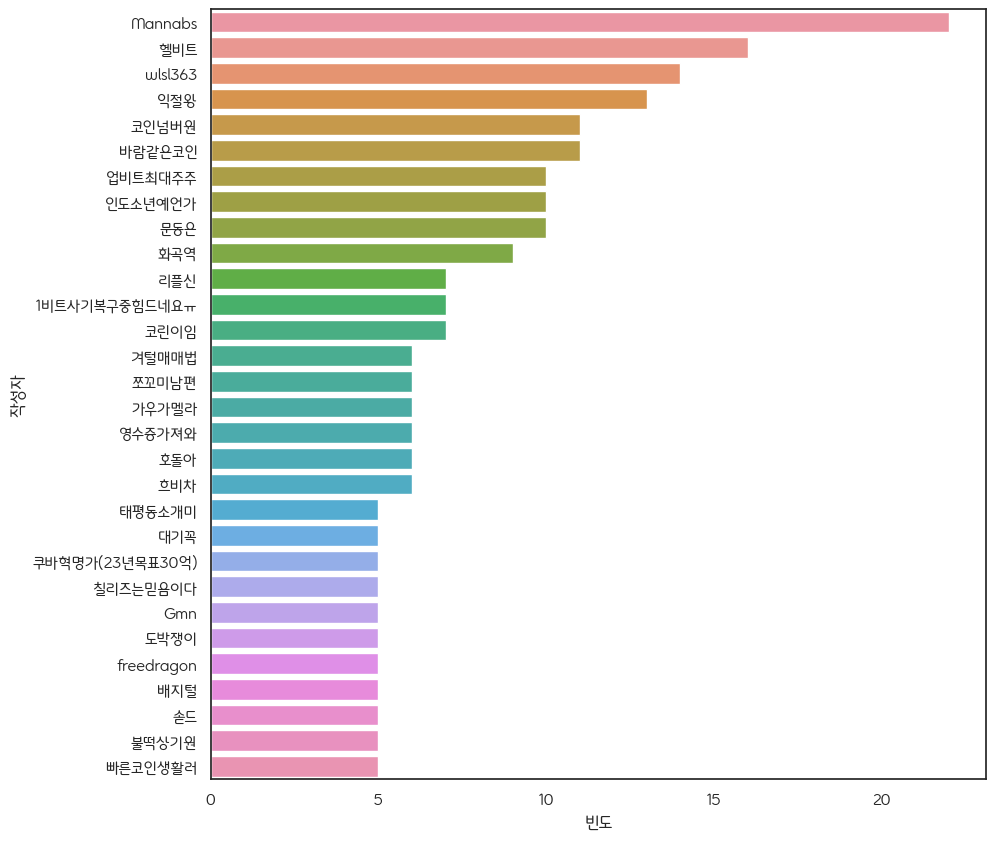

In [20]:
sns.barplot(data = names.head(30), x = '빈도', y = '작성자')

In [13]:
df.to_excel("./coinpan.xlsx")